In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import nltk
from nltk.corpus import stopwords

In [28]:
main_df = pd.read_csv("../data/animes_better.csv")
columns_to_drop = ['title', 'aired', 'episodes', 'members', 'ranked', 'score', 'link', 'img_url']
main_df = main_df.drop(columns=columns_to_drop)
main_df

,uid,synopsis,genre,popularity,Type,Producers,Studios,Source,Themes,Demographic,Duration,Favorites,Streaming Platforms
0,28891,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",141,TV,"['Dentsu', 'Mainichi Broadcasting System', 'Mo...",['Production I.G'],Manga,"['School', 'Team Sports']",Shounen,24.0,15764,['Crunchyroll']
1,23273,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",28,TV,"['Aniplex', 'Dentsu', 'Kodansha', 'Fuji TV', '...",['A-1 Pictures'],Manga,"['Love Polygon', 'Music', 'School']",Shounen,22.0,86357,"['Crunchyroll', 'Netflix']"
2,34599,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",98,TV,"['AT-X', 'Takeshobo', 'Sony Music Communicatio...",['Kinema Citrus'],Web manga,['Theme Unknown'],Demographic Unknown,25.0,44597,"['Crunchyroll', 'HIDIVE', 'Netflix']"
3,5114,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",4,TV,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...",['Bones'],Manga,['Theme Unknown'],Shounen,24.0,227331,['Crunchyroll']
4,31758,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",502,Movie,"['Aniplex', 'Kodansha']",['Shaft'],Light novel,['Theme Unknown'],Demographic Unknown,83.0,7588,['No Streaming Platform']
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,10075,All-new animation offered throughout UNIQLO cl...,"['Action', 'Comedy', 'Super Power', 'Martial A...",2382,OVA,['Producer Unknown'],['Pierrot'],Manga,['Theme Unknown'],Shounen,6.0,85,['No Streaming Platform']
16212,35828,High school student Sora Kashiwagi is accustom...,"['Slice of Life', 'Comedy', 'Supernatural']",1648,TV,"['TBS', 'Grooove', 'Nichion', 'Exit Tunes', 'O...",['8bit'],Web manga,"['Mythology', 'Pets', 'School']",Demographic Unknown,24.0,753,['Crunchyroll']
16213,10378,"After regaining her squid-like abilities, Ika ...","['Slice of Life', 'Comedy', 'Shounen']",1547,TV,"['TV Tokyo', 'Lantis', 'Pony Canyon', 'TV Toky...",['Diomedéa'],Manga,['Anthropomorphic'],Shounen,24.0,178,"['Crunchyroll', 'HIDIVE']"
16214,33082,"For years, the Niflheim Empire and the kingdom...",['Action'],2154,Movie,['Square Enix'],['Square Enix Visual Works'],Game,['Theme Unknown'],Demographic Unknown,115.0,154,['No Streaming Platform']


In [29]:
main_df['synopsis'] = main_df['synopsis'].fillna('')

stop_words = set(stopwords.words('english'))
stop_words.update(['anime','source'])
main_df['synopsis_clean'] = main_df['synopsis'].str.replace('[Written by MAL Rewrite]', '', regex=False)

def preprocess(text):
    tokens = [word for word in text.lower().split() if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

main_df['synopsis_clean'] = main_df['synopsis_clean'].apply(preprocess)

def extract_keywords(text):
    if not text.strip(): 
        return []
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10)
    try:
        tfidf_matrix = vectorizer.fit_transform([text])
        feature_names = vectorizer.get_feature_names_out()
        tfidf_scores = zip(feature_names, tfidf_matrix.toarray()[0])
        sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
        top_keywords = [word for word, score in sorted_tfidf_scores[:5]]
        return top_keywords
    except ValueError:
        return []

main_df['keywords'] = main_df['synopsis_clean'].apply(extract_keywords)

main_df[['uid','synopsis_clean', 'keywords']].head(10)

,uid,synopsis_clean,keywords
0,28891,following participation karasuno high school v...,"[volleyball, hope, karasuno, team, teams]"
1,23273,music accompanies path human prodigious pianis...,"[kousei, music, accompanies, note, passing]"
2,34599,gaping chasm stretching depths filled mysterio...,"[chasm, come, mysterious, whistle, white]"
3,5114,order something something equal value must alc...,"[alphonse, brothers, edward, colonel, equivalent]"
4,31758,helping revive legendary vampire koyomi ararag...,"[araragi, vampire, possible, turn, powerful]"
5,37510,shigeo kageyama maturing understanding role su...,"[reigen, supernatural, mob, psychic, remains]"
6,199,chihiro ogino less pleased parents discover ab...,"[parents, chihiro, meets, place, pleased]"
7,38000,ever since death burden supporting family fall...,"[tanjirou, family, demons, able, mysterious]"
8,35247,following encounter oddity specialist izuko hi...,"[araragi, student, alarmingly, mystery, oddity]"
9,2904,one year passed since black failed uprising ho...,"[black, accept, masked, mastermind, memory]"


In [30]:
main_df['keywords_str'] = main_df['keywords'].apply(lambda x: ' '.join(x))
vectorizer = CountVectorizer()
keyword_features = vectorizer.fit_transform(main_df['keywords_str'])

keywords_df = pd.DataFrame(keyword_features.toarray(), columns=vectorizer.get_feature_names_out())

main_df = pd.concat([main_df.reset_index(drop=True), keywords_df.reset_index(drop=True)], axis=1)

In [31]:
main_df = main_df.drop(['synopsis', 'synopsis_clean', 'keywords', 'keywords_str'], axis=1)

In [39]:
def safe_literal_eval(val):
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError):
        return val

def one_hot_encode_chunk(chunk, categorical_columns):
    encoder = OneHotEncoder()
    encoded_chunk = encoder.fit_transform(chunk[categorical_columns])
    encoded_df = pd.DataFrame(encoded_chunk.toarray(), columns=encoder.get_feature_names_out(categorical_columns))
    chunk = chunk.reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)
    return pd.concat([chunk, encoded_df], axis=1).drop(categorical_columns, axis=1)

In [40]:
for col in ['genre', 'Type', 'Producers', 'Studios', 'Source', 'Themes', 'Demographic', 'Streaming Platforms']:
    main_df[col] = main_df[col].apply(lambda x: ','.join(safe_literal_eval(x)) if isinstance(x, str) else x)

categorical_columns = ['genre', 'Type', 'Producers', 'Studios', 'Source', 'Themes', 'Demographic', 'Streaming Platforms']

chunks = np.array_split(main_df, 4)

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(one_hot_encode_chunk, chunk, categorical_columns) for chunk in chunks]
    results = [f.result() for f in futures]

main_df_encoded = pd.concat(results, ignore_index=True)

e:\Python\GitHub\anime-data-analytics-project\venv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
numeric_cols = main_df_encoded.select_dtypes(include=[np.number]).columns
non_numeric_cols = main_df_encoded.select_dtypes(exclude=[np.number]).columns

main_df_encoded[numeric_cols] = main_df_encoded[numeric_cols].fillna(main_df_encoded[numeric_cols].mean())
main_df_encoded[non_numeric_cols] = main_df_encoded[non_numeric_cols].fillna('Unknown')
main_df_encoded = main_df_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)

In [ ]:
final_features = main_df_encoded
final_features = final_features.drop(columns=['uid', 'popularity', 'Favorites'])

target = main_df['popularity']

X_train, X_test, y_train, y_test = train_test_split(final_features, target, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 1.4659833054514162e+25
R^2 Score: -6.546407400174153e+17


In [ ]:
coefficients = pd.DataFrame({'Feature': final_features.columns, 'Coefficient': model.coef_})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

print(coefficients.head(10))
print(coefficients.tail(10))

                                                Feature   Coefficient
2     genre_['Action', 'Adventure', 'Comedy', 'Demon...  1.156916e+14
23    genre_['Action', 'Adventure', 'Comedy', 'Histo...  5.026018e+13
3819                     Themes_['Detective', 'Racing']  2.165581e+13
1685                                           Type_OVA  2.103523e+13
1686                                            Type_PV  2.103523e+13
1689                                    Type_TV Special  2.103523e+13
1684                                           Type_ONA  2.103523e+13
1681                                            Type_CM  2.103523e+13
1683                                         Type_Music  2.103523e+13
1687                                       Type_Special  2.103523e+13
                                                Feature   Coefficient
1     genre_['Action', 'Adventure', 'Cars', 'Comedy'... -2.211578e+13
24    genre_['Action', 'Adventure', 'Comedy', 'Histo... -2.370506e+13
4111  genre_['Action

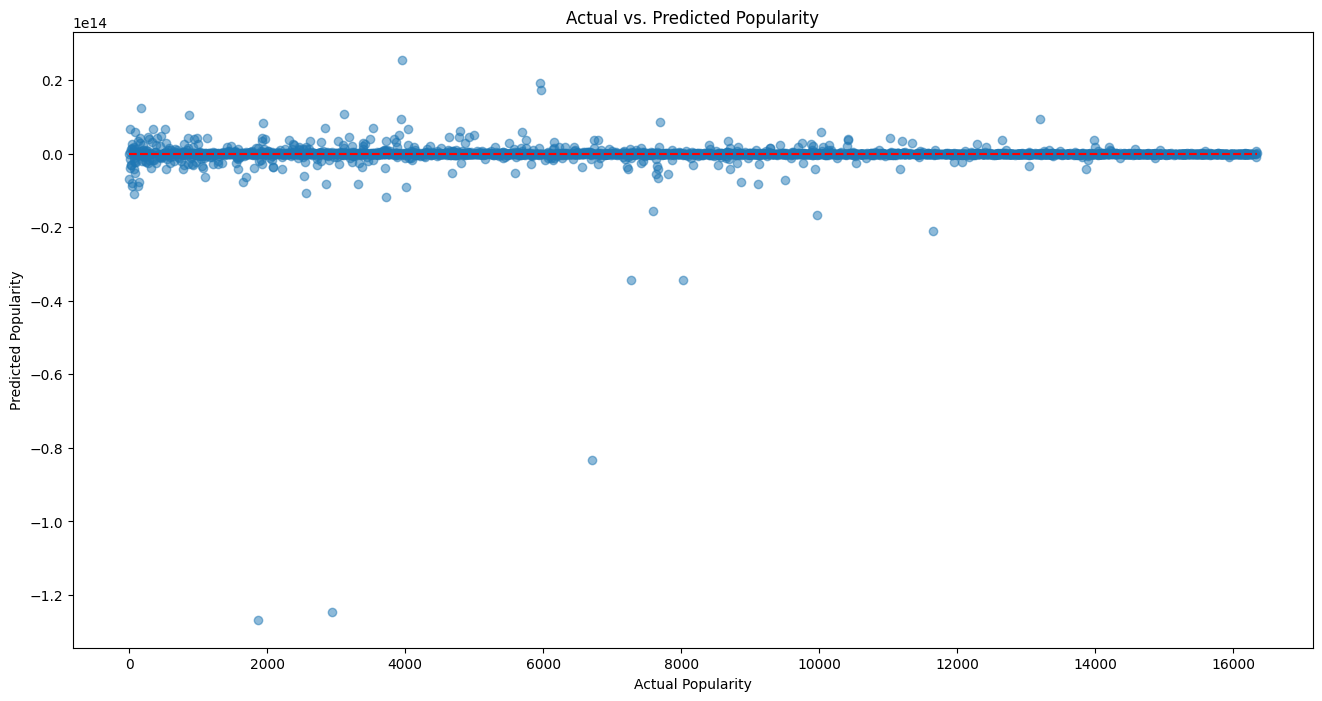

In [ ]:
plt.figure(figsize=(16, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs. Predicted Popularity')
plt.show()

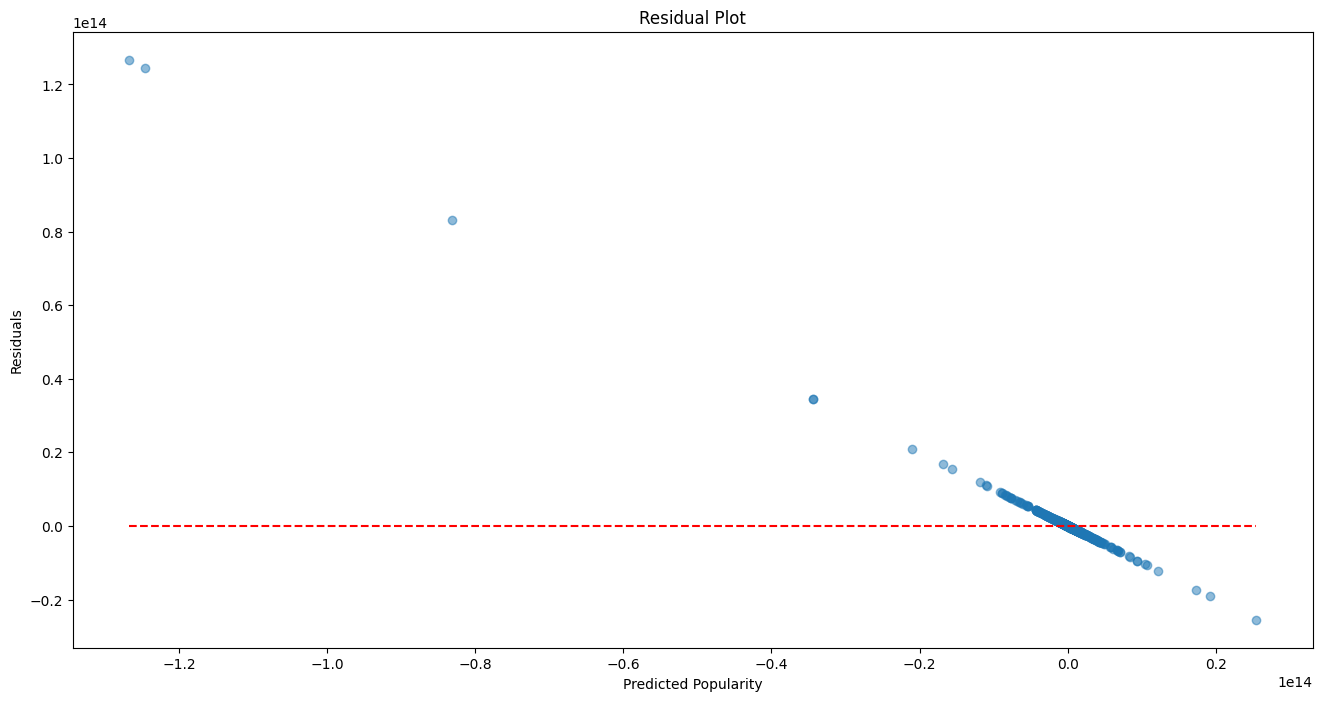

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(16, 8))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), color='red', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

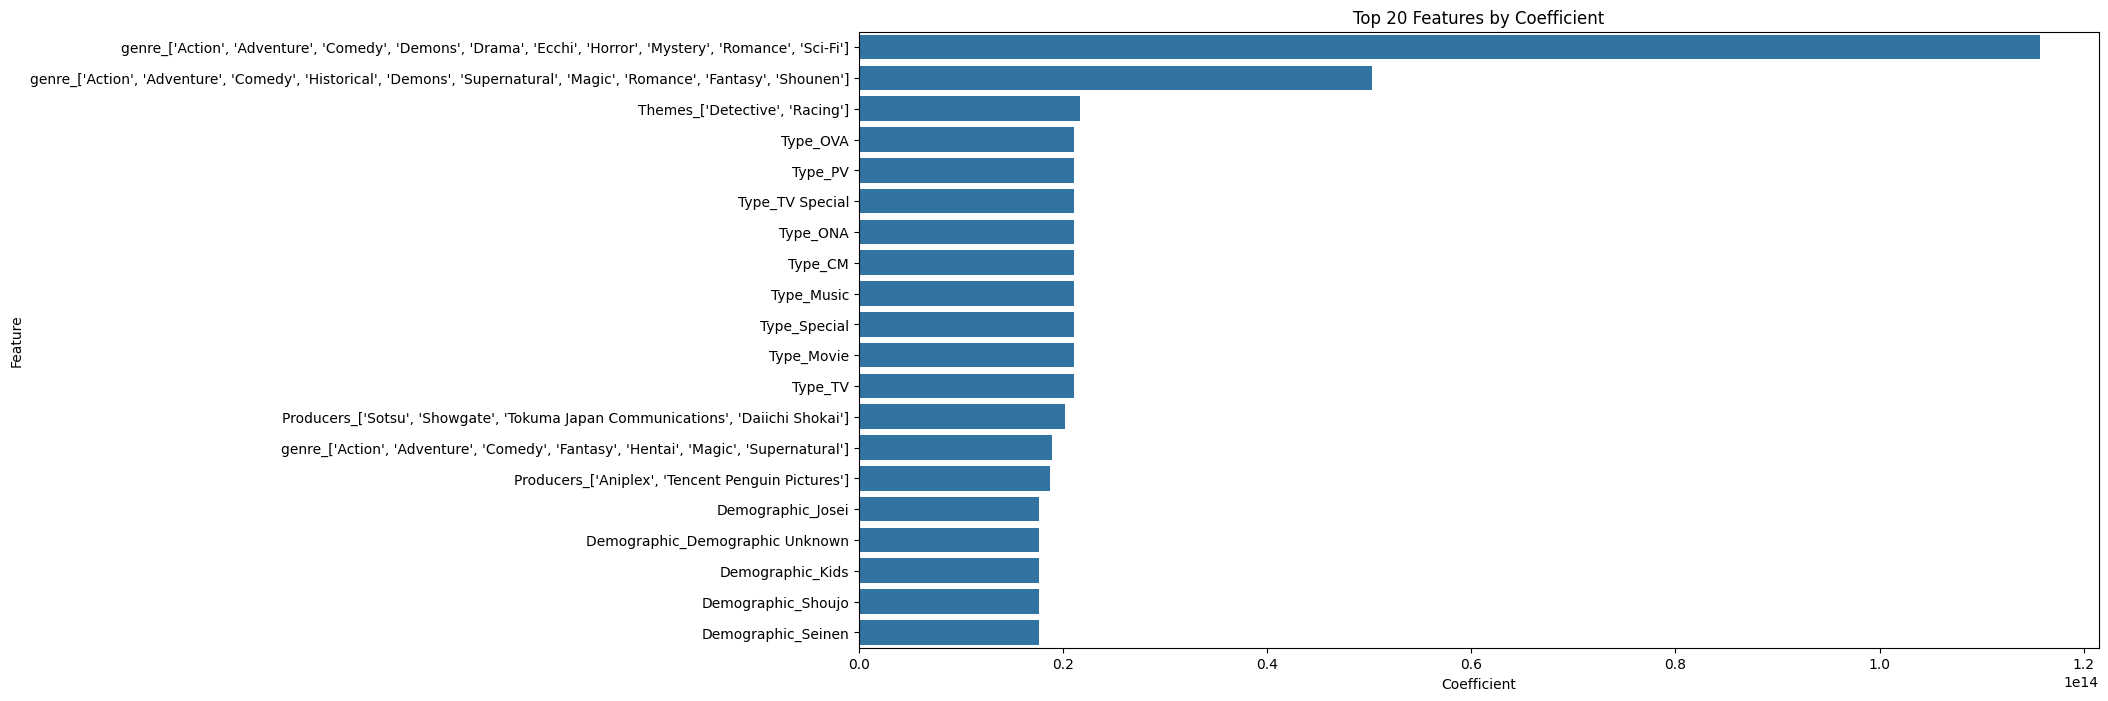

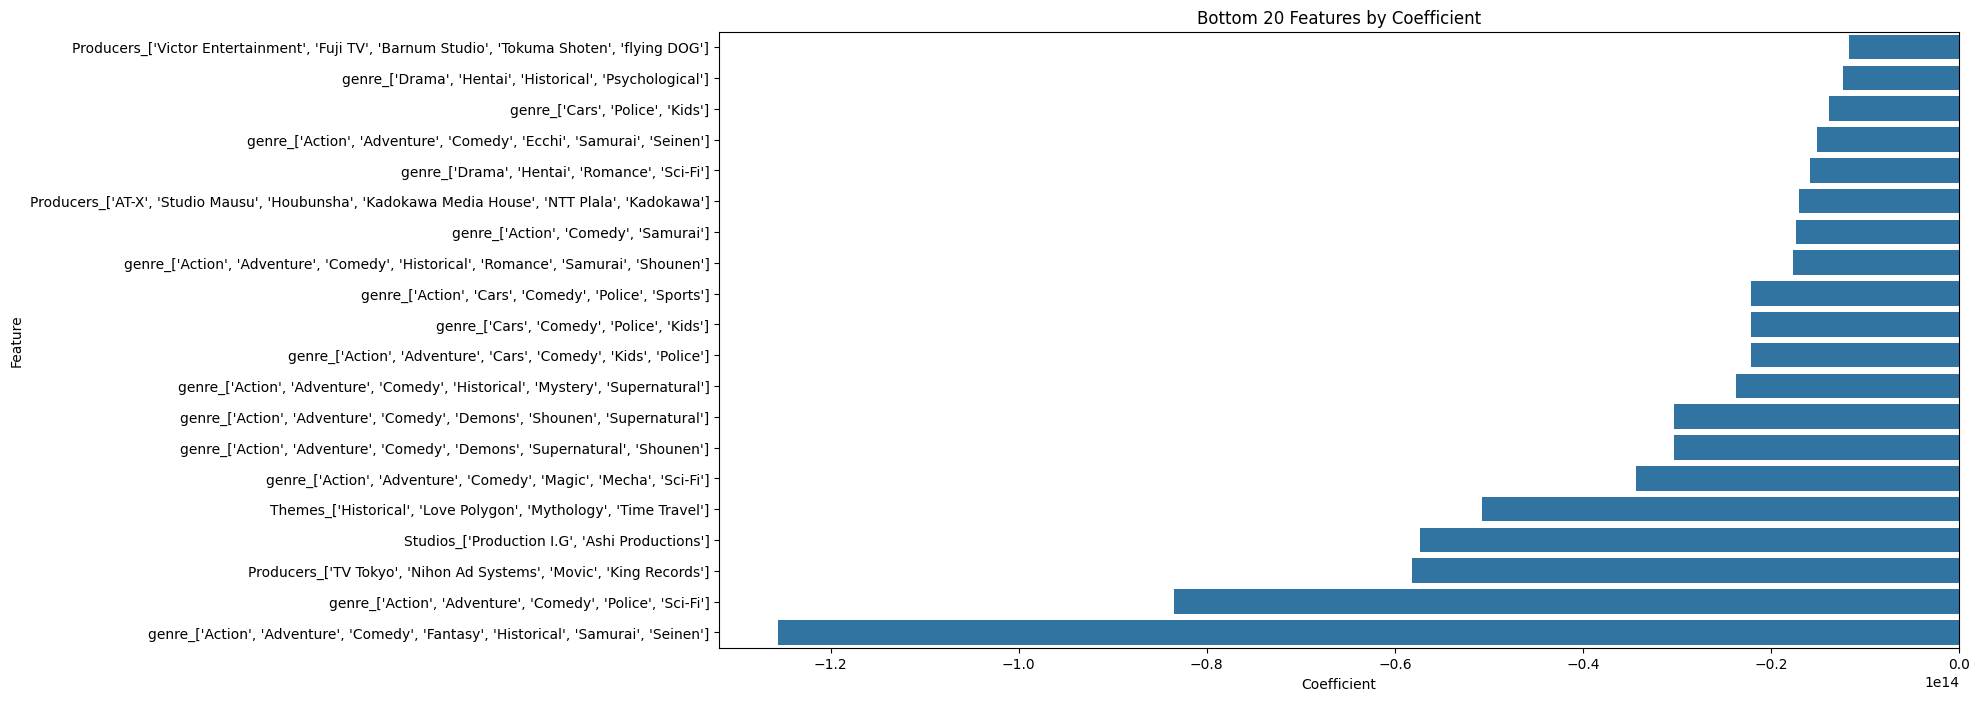

In [ ]:
plt.figure(figsize=(16, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients.head(20))
plt.title('Top 20 Features by Coefficient')
plt.show()

plt.figure(figsize=(16, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients.tail(20))
plt.title('Bottom 20 Features by Coefficient')
plt.show()